In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from torch.optim import SGD
from torchcp.classification.scores import APS, RAPS, SAPS, THR
from torchcp.classification.predictors import ClusterPredictor, WeightedPredictor, ClassWisePredictor, SplitPredictor

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

STEP=5
GAMMA=0.5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [5]:
torch.cuda.empty_cache()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)  # 输入通道数为3（RGB图像），输出通道数为64
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64 * 32 * 32, 10)  # 全连接层输入大小需匹配卷积层输出大小

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1, 64 * 32 * 32)  # 将特征图展平为一维
        x = self.fc2(x)
        return x

model = ConvModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # 将输入和标签移动到GPU
        optimizer.zero_grad()

        # 正向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

Epoch 1, Loss: 1.7774055309002967
Epoch 2, Loss: 1.537331630811667
Epoch 3, Loss: 1.470030691312707
Epoch 4, Loss: 1.4124268933635233
Epoch 5, Loss: 1.380044946890048
Epoch 6, Loss: 1.3358817295650083
Epoch 7, Loss: 1.3033767017866948
Epoch 8, Loss: 1.2761170516538498
Epoch 9, Loss: 1.2551744343984463
Epoch 10, Loss: 1.2340412434104764
Epoch 11, Loss: 1.220836398546653
Epoch 12, Loss: 1.201278727377772
Epoch 13, Loss: 1.1915309513011552
Epoch 14, Loss: 1.181771892720781
Epoch 15, Loss: 1.1728719125318405
Epoch 16, Loss: 1.165928053276618
Epoch 17, Loss: 1.1571593097103832
Epoch 18, Loss: 1.1474064026037445
Epoch 19, Loss: 1.1416150221739279
Epoch 20, Loss: 1.138734718265436
Epoch 21, Loss: 1.1334885448750938
Epoch 22, Loss: 1.129354866416863
Epoch 23, Loss: 1.1268813668004691
Epoch 24, Loss: 1.1238923801485534
Epoch 25, Loss: 1.1149520088949472
Epoch 26, Loss: 1.1161019253303937
Epoch 27, Loss: 1.1092852111667624
Epoch 28, Loss: 1.1082089650051674
Epoch 29, Loss: 1.102389965673237
Epoc

SplitPredictor with RAPS - Coverage Rate: 0.9004, Average Set Size: 2.7081


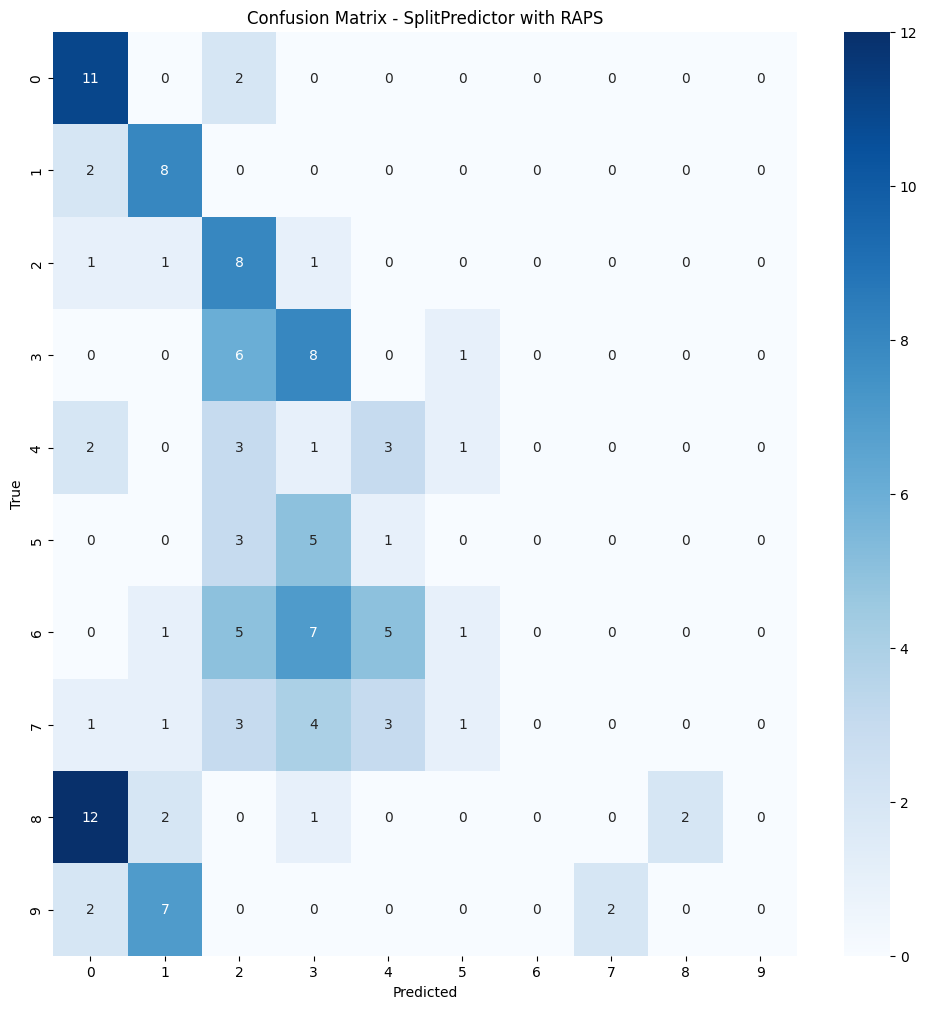

ClassWisePredictor with RAPS - Coverage Rate: 0.9009, Average Set Size: 2.7492


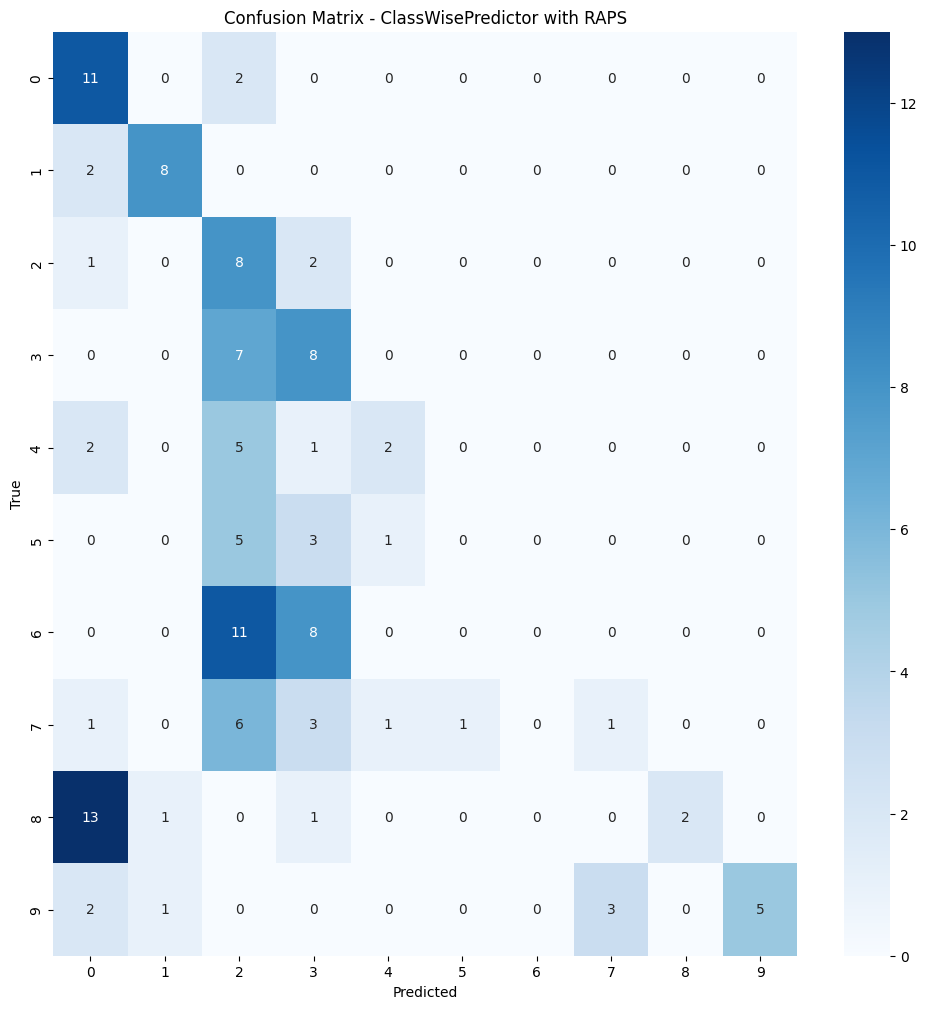

ClusterPredictor with RAPS - Coverage Rate: 0.9008, Average Set Size: 2.7302


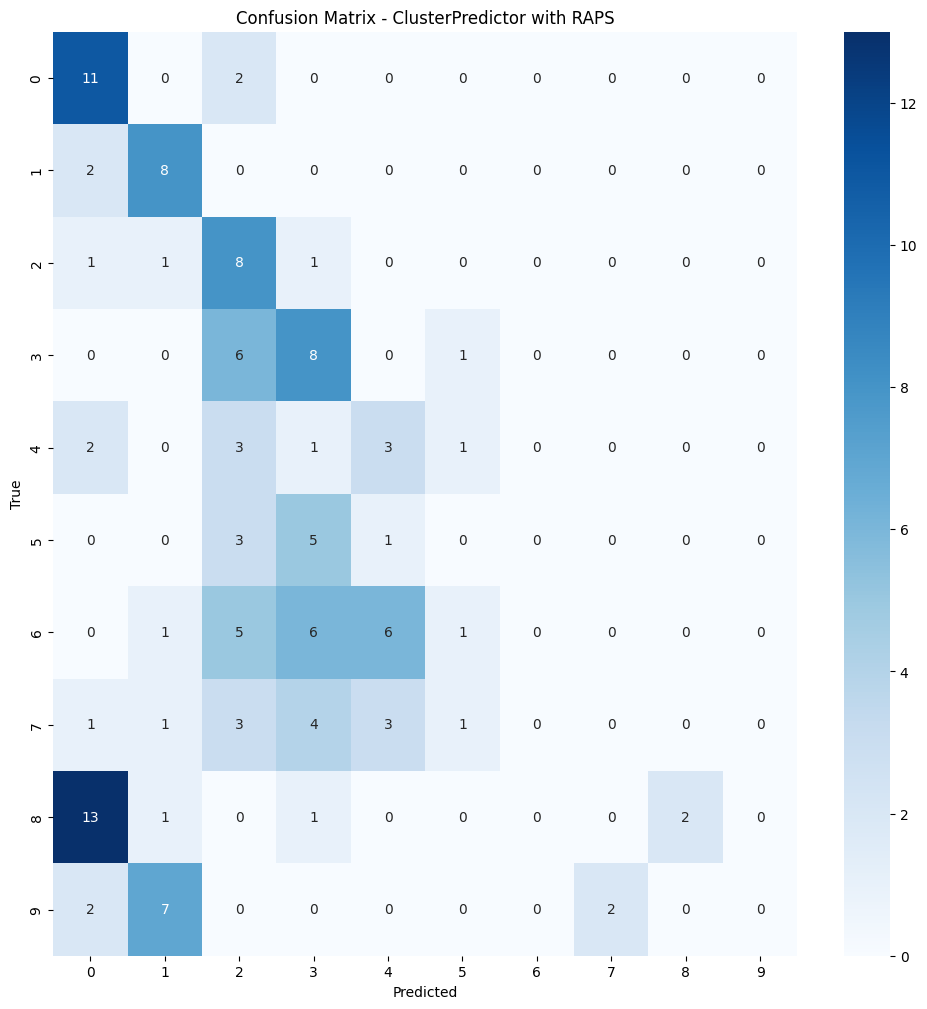

SplitPredictor with SAPS - Coverage Rate: 0.9001, Average Set Size: 2.8007


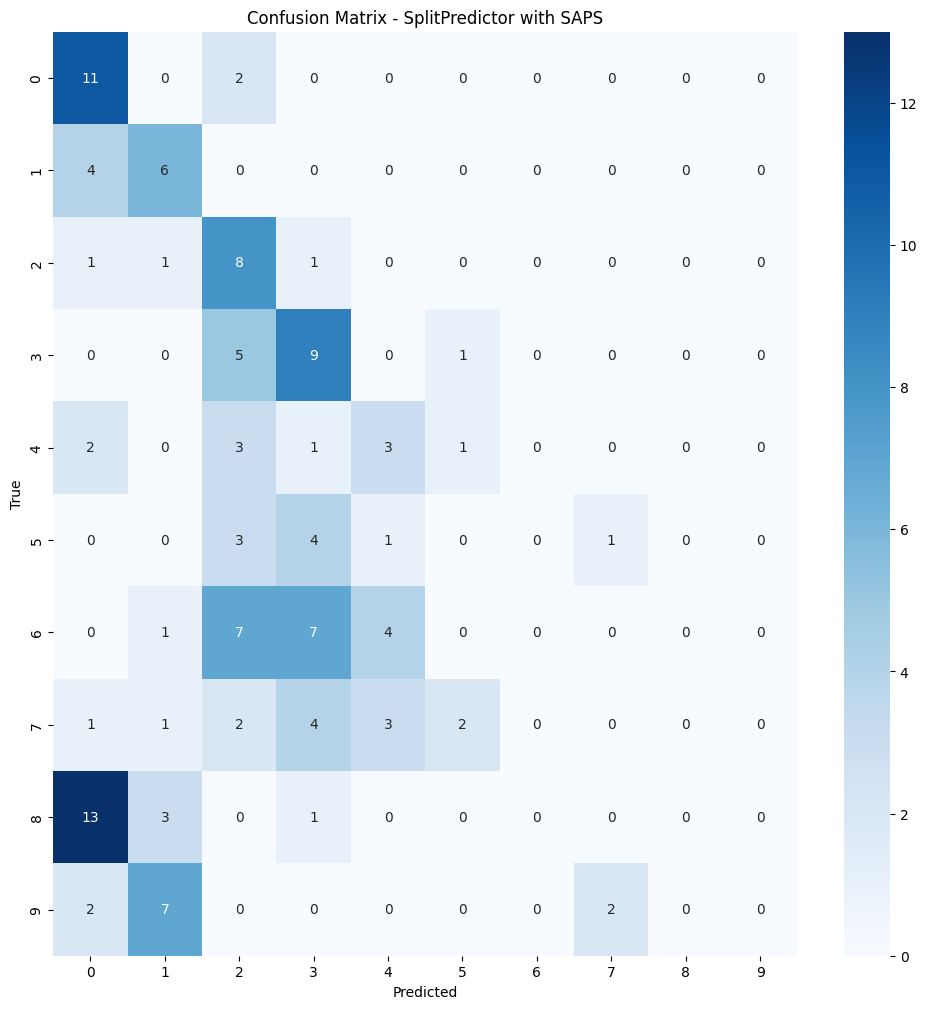

ClassWisePredictor with SAPS - Coverage Rate: 0.9006, Average Set Size: 2.8393


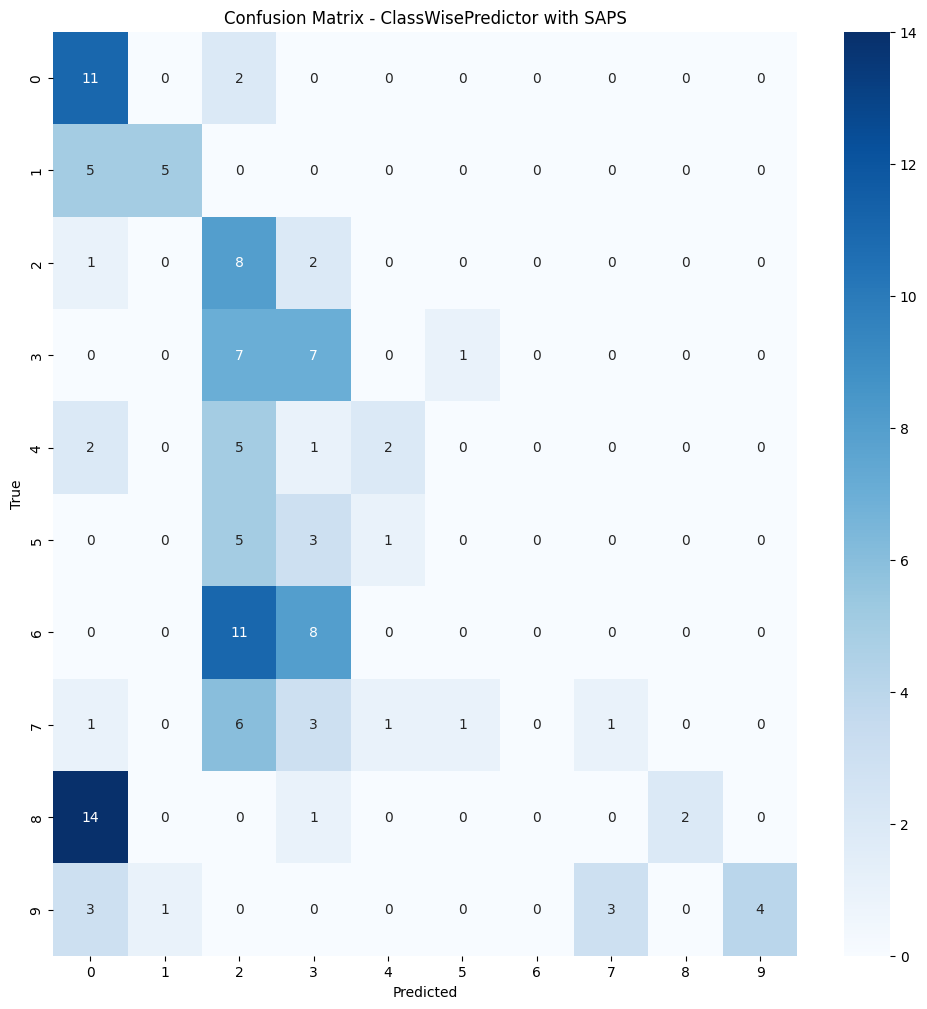

ClusterPredictor with SAPS - Coverage Rate: 0.8985, Average Set Size: 2.7675


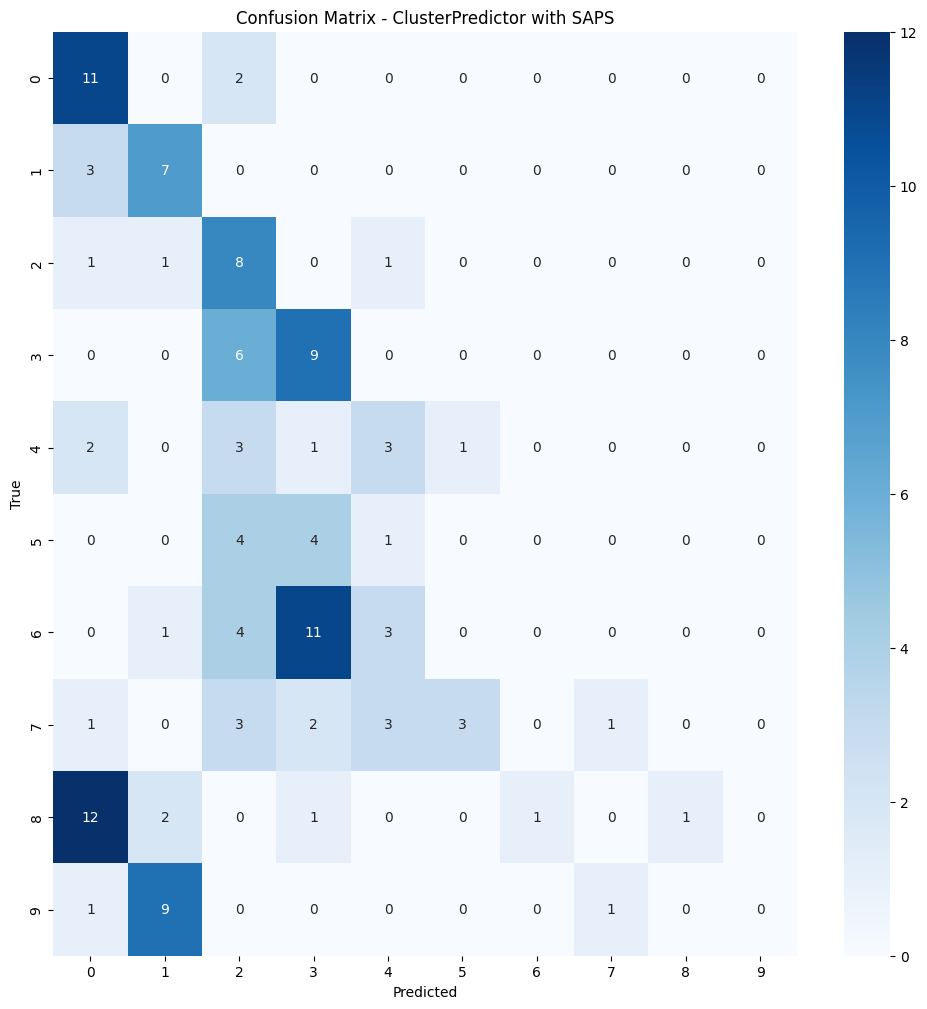

SplitPredictor with APS - Coverage Rate: 0.902, Average Set Size: 2.719


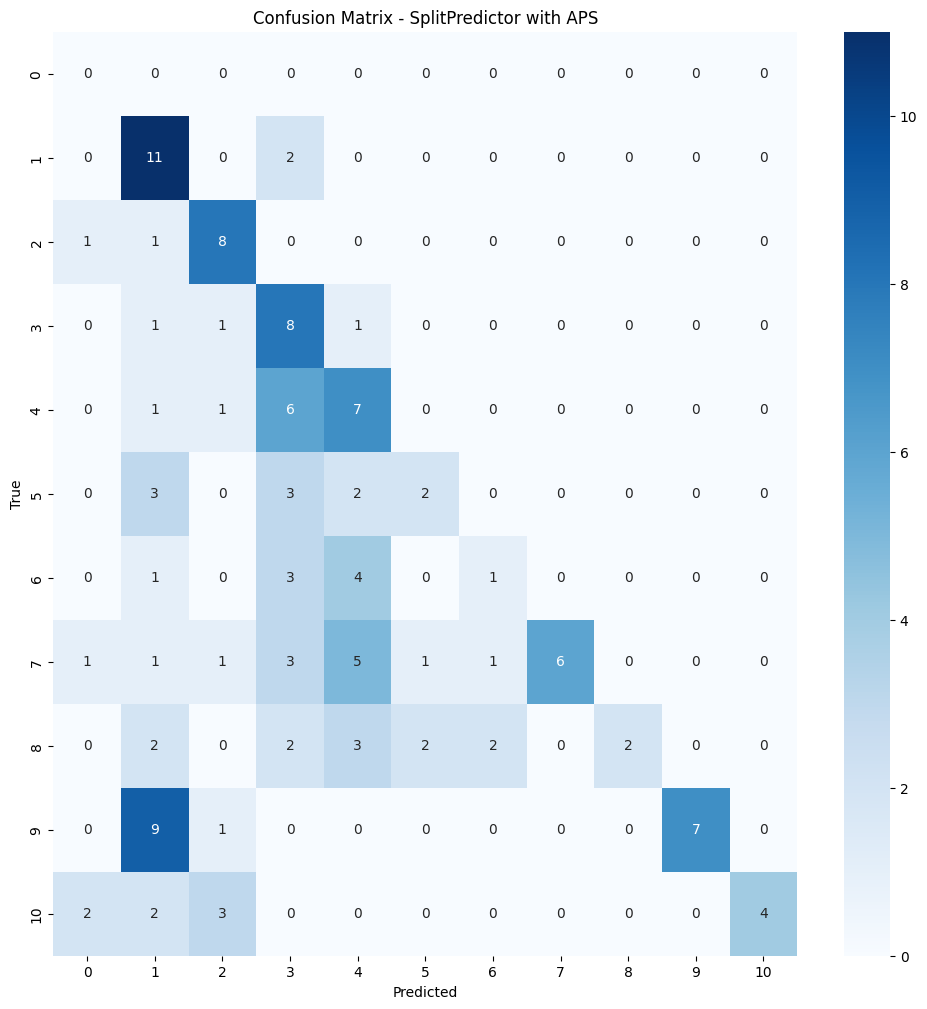

ClassWisePredictor with APS - Coverage Rate: 0.9019, Average Set Size: 2.7501


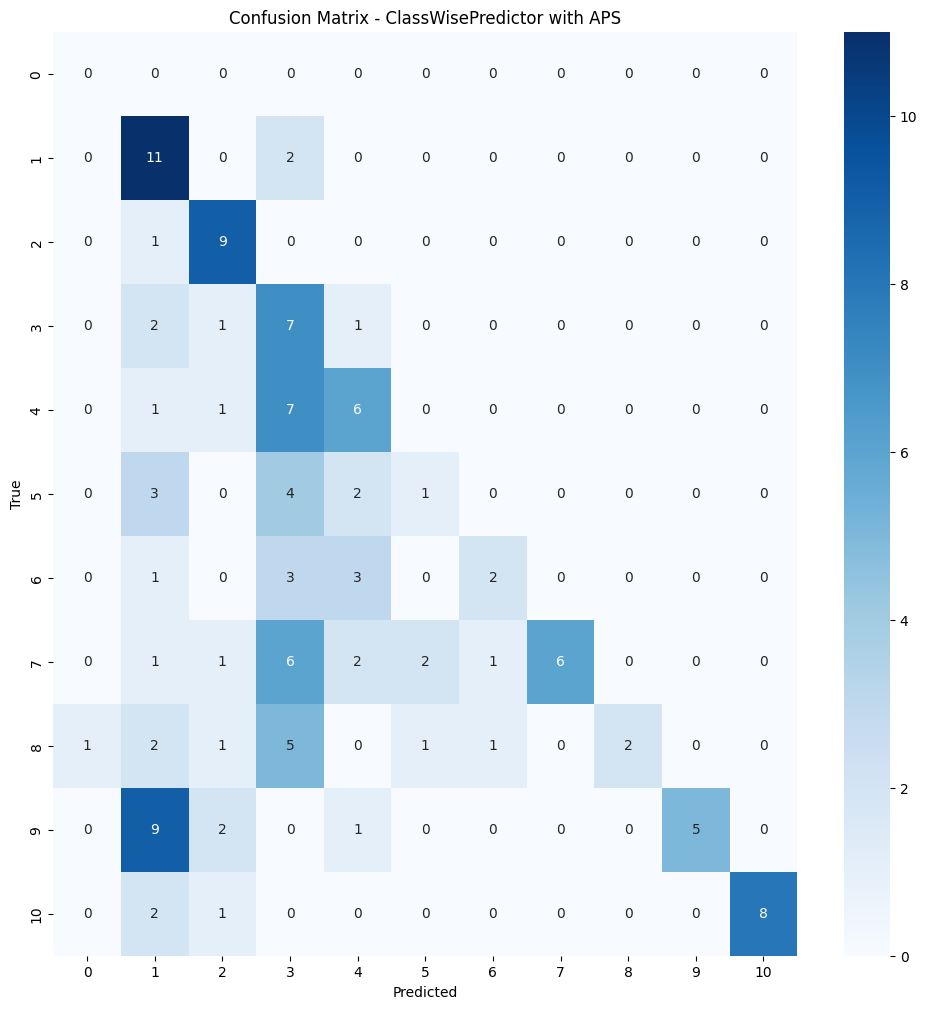

ClusterPredictor with APS - Coverage Rate: 0.9012, Average Set Size: 2.6967


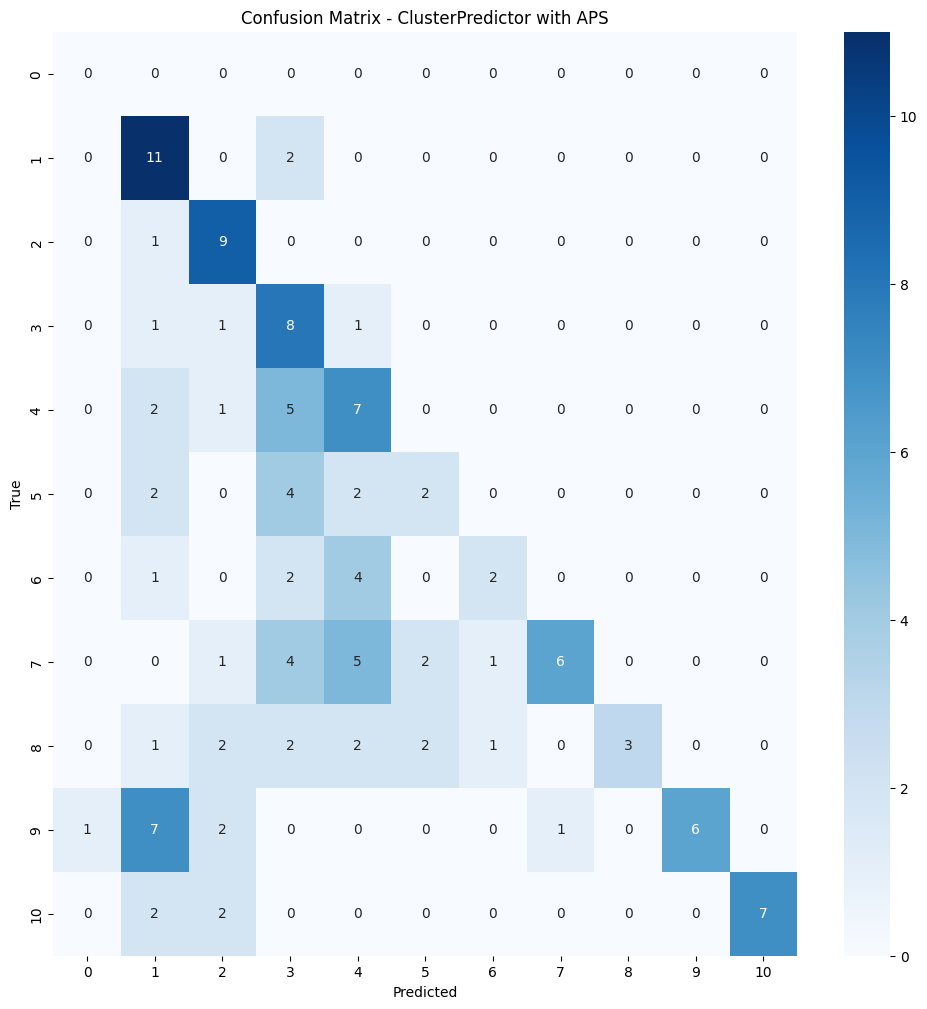

SplitPredictor with THR - Coverage Rate: 0.9, Average Set Size: 2.3425


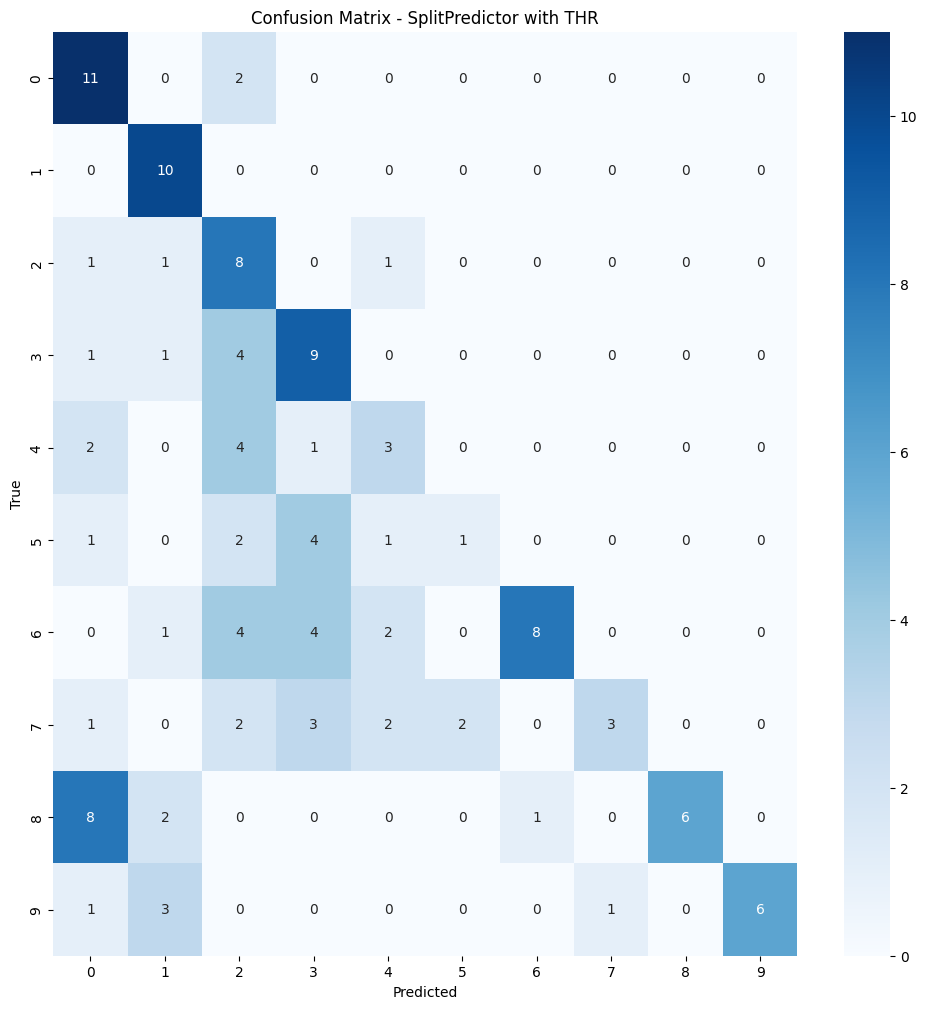

ClassWisePredictor with THR - Coverage Rate: 0.9, Average Set Size: 2.3393


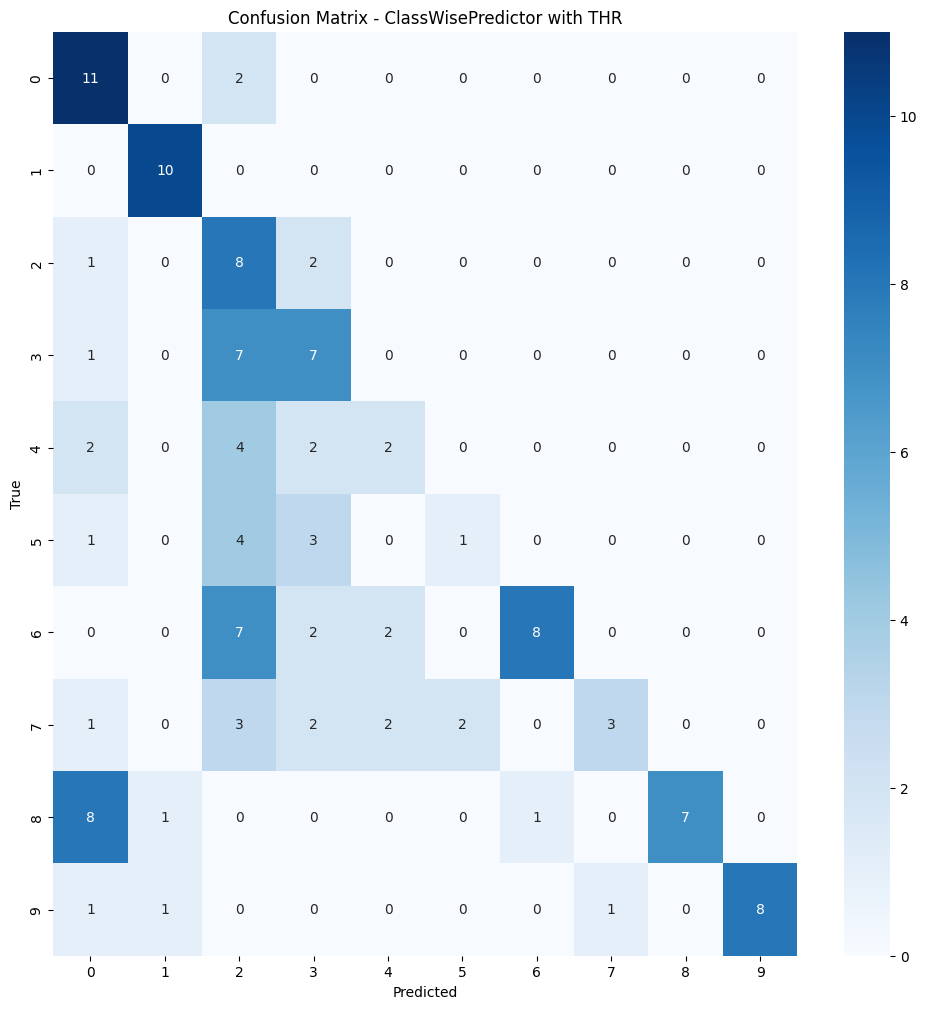

ClusterPredictor with THR - Coverage Rate: 0.9, Average Set Size: 2.3424


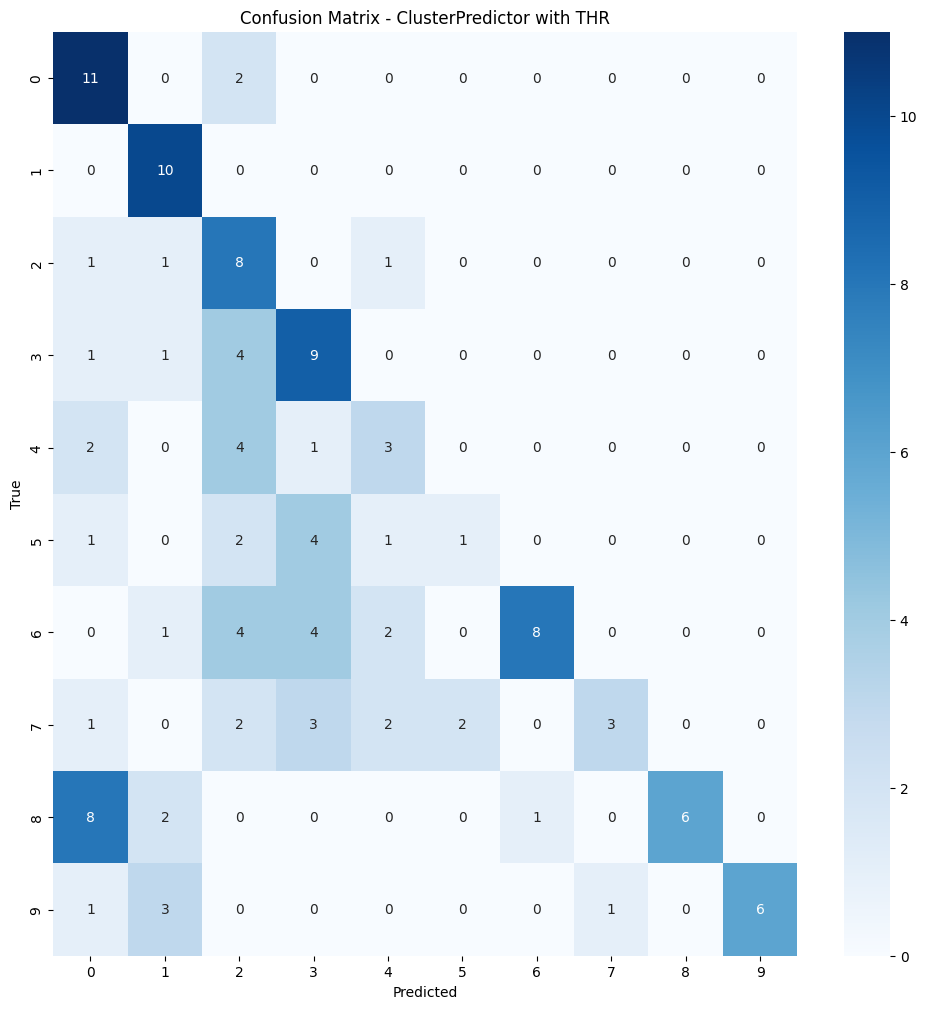

In [7]:
# 可视化结果
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 定义评分函数和预测器的映射
score_functions = {
    'RAPS': RAPS(penalty=1.0),
    'SAPS': SAPS(weight=1.0),
    'APS': APS(),
    'THR': THR()
}

predictors = {
    'SplitPredictor': SplitPredictor,
    'ClassWisePredictor': ClassWisePredictor,
    'ClusterPredictor': ClusterPredictor
}

# 初始化存储结果的数组
coverage_rates = []
average_sizes = []
combination_labels = []

# 循环测试每个评分函数和预测器的组合
for score_name, score_func in score_functions.items():
    for predictor_name, Predictor in predictors.items():
        predictor = Predictor(score_function=score_func, model=model)

        # 校准预测器
        predictor.calibrate(test_dataloader, alpha=0.1)

        all_predict_sets = []
        all_true_labels = []

        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                predict_sets = predictor.predict(inputs)
                all_predict_sets.extend(predict_sets)
                all_true_labels.extend(labels.cpu().numpy())

                # For simplicity, we use only one batch for demonstration
                break

        # Calculate coverage rate and average set size
        result_dict = predictor.evaluate(test_dataloader)
        print(f'{predictor_name} with {score_name} - Coverage Rate: {result_dict["Coverage_rate"]}, Average Set Size: {result_dict["Average_size"]}')

        # 更新结果数组
        coverage_rates.append(result_dict["Coverage_rate"])
        average_sizes.append(result_dict["Average_size"])
        combination_labels.append(f'{predictor_name} with {score_name}')  # 使用更新后的变量名

        # Visualize the results
        single_predictions = [p[0] if p else -1 for p in all_predict_sets]  # Use -1 for empty sets
        cm = confusion_matrix(all_true_labels, single_predictions)

        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {predictor_name} with {score_name}')
        plt.show()

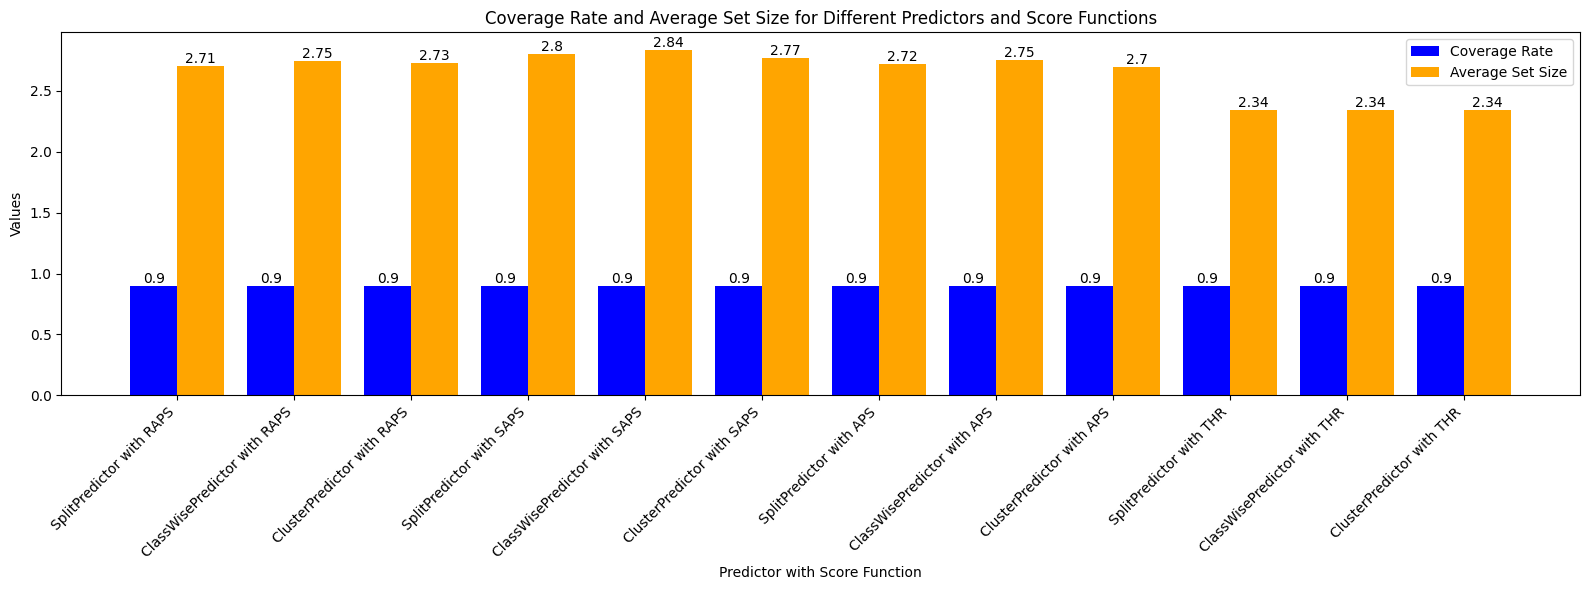

In [10]:
# 设置柱状图参数
x = range(len(combination_labels))  # 横坐标位置
width = 0.4  # 柱子的宽度

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x, coverage_rates, width, label='Coverage Rate', color='blue')
bars2 = ax.bar([p + width for p in x], average_sizes, width, label='Average Set Size', color='orange')

# 添加标签和标题
ax.set_xlabel('Predictor with Score Function')
ax.set_ylabel('Values')
ax.set_title('Coverage Rate and Average Set Size for Different Predictors and Score Functions')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(combination_labels, rotation=45, ha='right')
ax.legend()

# 在柱状图上添加数据标签
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# 显示图表
plt.tight_layout()
plt.show()